## **Imports**

In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from random import choice
from scipy import ndimage
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
%matplotlib inline

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras import backend as K

tf.random.set_seed(0)

## **Montar en entorno de trabajo grupal de Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls

drive/  sample_data/


In [ ]:
working_dir = "/content/drive/MyDrive/TAC-TA/Data Augmentation"
%cd $working_dir

/content/drive/MyDrive/TAC-TA/Data Augmentation


## **Lectura de imágenes**

In [ ]:
path = 'Cerebral-Tumor-Images/'

In [ ]:
glioma_tumor_paths = [("./data/glioma_tumor/" + x) for x in os.listdir("./data/glioma_tumor")]

meningioma_tumor_paths = [("./data/meningioma_tumor/" + x) for x in os.listdir("./data/meningioma_tumor")]

no_tumor_paths = [("./data/no_tumor/" + x) for x in os.listdir("./data/no_tumor")]

pituitary_tumor_paths = [("./data/pituitary_tumor/" + x) for x in os.listdir("./data/pituitary_tumor")]

print("glioma_tumor scan with length of: {}".format(len(glioma_tumor_paths)))
print("meningioma_tumor scan with length of: {}".format(len(meningioma_tumor_paths)))
print("no_tumor scan with length of: {}".format(len(no_tumor_paths)))
print("pituitary_tumor scan with length of: {}".format(len(pituitary_tumor_paths)))

glioma_tumor scan with length of: 1000
meningioma_tumor scan with length of: 1000
no_tumor scan with length of: 1000
pituitary_tumor scan with length of: 1000


In [ ]:
glioma_tumor_paths[:5]

['./data/glioma_tumor/gg (190).jpg',
 './data/glioma_tumor/gg (794).jpg',
 './data/glioma_tumor/gg (732).jpg',
 './data/glioma_tumor/gg (468).jpg',
 './data/glioma_tumor/gg (470).jpg']

In [ ]:
meningioma_tumor_paths[:5]

['./data/meningioma_tumor/m1(171).jpg',
 './data/meningioma_tumor/m1(131).jpg',
 './data/meningioma_tumor/m1(114).jpg',
 './data/meningioma_tumor/m3 (206).jpg',
 './data/meningioma_tumor/m3 (96).jpg']

In [ ]:
no_tumor_paths[:5]

['./data/no_tumor/image(256).jpg',
 './data/no_tumor/image(295).jpg',
 './data/no_tumor/image(127).jpg',
 './data/no_tumor/image(19).jpg',
 './data/no_tumor/image(400).jpg']

In [ ]:
pituitary_tumor_paths[:5]

['./data/pituitary_tumor/image(61).jpg',
 './data/pituitary_tumor/p (544).jpg',
 './data/pituitary_tumor/p (824).jpg',
 './data/pituitary_tumor/p (511).jpg',
 './data/pituitary_tumor/p (658).jpg']

Asignar las etiquetas a las tomografías computarizadas

no_tumor Scans -> 0

meningioma_tumor Scans -> 1

glioma_tumorglioma_tumor Scans -> 2

pituitary_tumor Scans -> 3

In [ ]:
preprocess_image = tf.keras.Sequential([
  tf.keras.layers.Resizing(224, 224),
  tf.keras.layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2, fill_mode='constant'),
  tf.keras.layers.RandomCrop(180,180),
  tf.keras.layers.Resizing(224,224),
  tf.keras.layers.RandomContrast(0.5)
])

In [ ]:
def augment_image(path):
  im = Image.open(path)
  im = im.resize((224, 224))

  x = np.asarray(im, np.float32)
  x = x[None]

  x = data_augmentation(x)

  x = x.numpy().reshape(224,224,3)

  x = x.astype(np.uint8)

  return Image.fromarray(x)

## **Image Augmentation: Nivelar distribución a 1000 por clase**.

In [ ]:
import random

for index, img_path in enumerate(random.sample(no_tumor_paths, 1000 - len(no_tumor_paths))):
  augmented = augment_image(img_path)
  augmented.save('./data/no_tumor/AG_({}).jpg'.format(index+1))

In [ ]:
import random

for index, img_path in enumerate(random.sample(glioma_tumor_paths, 1000 - len(glioma_tumor_paths))):
  augmented = augment_image(img_path)
  augmented.save('./data/glioma_tumor/AG_({}).jpg'.format(index+1))

In [ ]:
for index, img_path in enumerate(random.sample(meningioma_tumor_paths, 1000 - len(meningioma_tumor_paths))):
  augmented = augment_image(img_path)
  augmented.save('./data/meningioma_tumor/AG_1({}).jpg'.format(index+1))

In [ ]:
for index, img_path in enumerate(random.sample(pituitary_tumor_paths, 1000 - len(pituitary_tumor_paths))):
  augmented = augment_image(img_path)
  augmented.save('./data/pituitary_tumor/AG_({}).jpg'.format(index+1))

## **Configurando los hiperparametros**

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 20
image_size = 224
patch_size = 36  
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 8
mlp_head_units = [2048, 1024]

## **Lectura de dataset desde directorio**

In [ ]:
path = 'data'

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_image, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    path, 
    target_size=(image_size, image_size), 
    shuffle=True, 
    color_mode="rgb", 
    class_mode="sparse", 
    batch_size=batch_size, 
    subset="training")
validation_generator = train_datagen.flow_from_directory(
    path, 
    target_size=(image_size, image_size), 
    shuffle=False, 
    color_mode="rgb", 
    class_mode="sparse", 
    batch_size=batch_size, 
    subset="validation")

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


## **Multilayer Perceptron**

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## **Creacion de patches como capa**

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

## **Muestra de la creacion de patches en una imagen**

Image size: 224 X 224
Patch size: 36 X 36
Patches per image: 36
Elements per patch: 3888


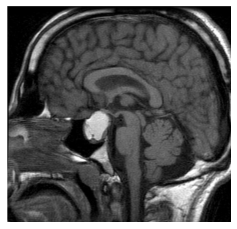

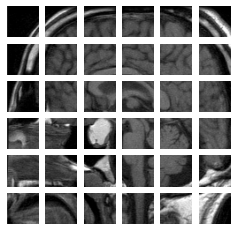

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = plt.imread("./data/pituitary_tumor/image(61).jpg")
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## **Capa de encodeado de patch**

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## **Modelo con Transformer ViT B16**

In [ ]:
def create_vit_classifier(input_shape,num_classes):
    inputs = layers.Input(shape=input_shape)
    # Creacion de patches
    patches = Patches(patch_size)(inputs)
    # Encodeado de patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    # Creacion de multiples capas de un bloque transformador.
    for _ in range(transformer_layers):
        # Capa de normalizacion
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Capa de multihead attention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Salto de conexion
        x2 = layers.Add()([attention_output, encoded_patches])
        # Capa de normalizacion
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Salto de conexion
        encoded_patches = layers.Add()([x3, x2])
    # Crear un [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Salida de clasificacion
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def show_results(log):
  loss = log.history['loss']
  acc = log.history['accuracy']

  val_loss = log.history['val_loss']
  val_acc = log.history['val_accuracy']
  
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  ax1, ax2 = axes

  ax1.plot(loss, label='train')
  ax1.plot(val_loss, label='test')
  
  ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
  
  ax2.plot(acc, label='train')
  ax2.plot(val_acc, label='test')
  
  ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
  
  for ax in axes: ax.legend()

## **Compilacion y entrenamiento**

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=num_epochs,
        callbacks=[checkpoint_callback]
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(validation_generator)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier((image_size,image_size,3),4)
history = run_experiment(vit_classifier)

Epoch 1/20
50/50 [==============================] - 190s 4s/step - loss: 1.8459 - accuracy: 0.4125 - top-5-accuracy: 1.0000 - val_loss: 1.3715 - val_accuracy: 0.3162 - val_top-5-accuracy: 1.0000
Epoch 2/20
50/50 [==============================] - 72s 1s/step - loss: 1.1584 - accuracy: 0.5166 - top-5-accuracy: 1.0000 - val_loss: 1.8288 - val_accuracy: 0.3237 - val_top-5-accuracy: 1.0000
Epoch 3/20
50/50 [==============================] - 73s 1s/step - loss: 0.9634 - accuracy: 0.6175 - top-5-accuracy: 1.0000 - val_loss: 1.5472 - val_accuracy: 0.3625 - val_top-5-accuracy: 1.0000
Epoch 4/20
50/50 [==============================] - 72s 1s/step - loss: 0.7757 - accuracy: 0.7072 - top-5-accuracy: 1.0000 - val_loss: 1.8657 - val_accuracy: 0.3525 - val_top-5-accuracy: 1.0000
Epoch 5/20
50/50 [==============================] - 70s 1s/step - loss: 0.6932 - accuracy: 0.7422 - top-5-accuracy: 1.0000 - val_loss: 1.9529 - val_accuracy: 0.3775 - val_top-5-accuracy: 1.0000
Epoch 6/20
50/50 [===========

In [ ]:
history = vit_classifier.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=num_epochs
    )

Epoch 1/20
50/50 [==============================] - 73s 1s/step - loss: 0.2794 - accuracy: 0.8941 - top-5-accuracy: 1.0000 - val_loss: 2.9158 - val_accuracy: 0.5238 - val_top-5-accuracy: 1.0000
Epoch 2/20
50/50 [==============================] - 71s 1s/step - loss: 0.2409 - accuracy: 0.9072 - top-5-accuracy: 1.0000 - val_loss: 3.7460 - val_accuracy: 0.5562 - val_top-5-accuracy: 1.0000
Epoch 3/20
50/50 [==============================] - 72s 1s/step - loss: 0.2625 - accuracy: 0.9059 - top-5-accuracy: 1.0000 - val_loss: 4.9003 - val_accuracy: 0.5362 - val_top-5-accuracy: 1.0000
Epoch 4/20
50/50 [==============================] - 72s 1s/step - loss: 0.2201 - accuracy: 0.9187 - top-5-accuracy: 1.0000 - val_loss: 4.0826 - val_accuracy: 0.5925 - val_top-5-accuracy: 1.0000
Epoch 5/20
50/50 [==============================] - 72s 1s/step - loss: 0.2113 - accuracy: 0.9191 - top-5-accuracy: 1.0000 - val_loss: 4.3165 - val_accuracy: 0.5500 - val_top-5-accuracy: 1.0000
Epoch 6/20
50/50 [============

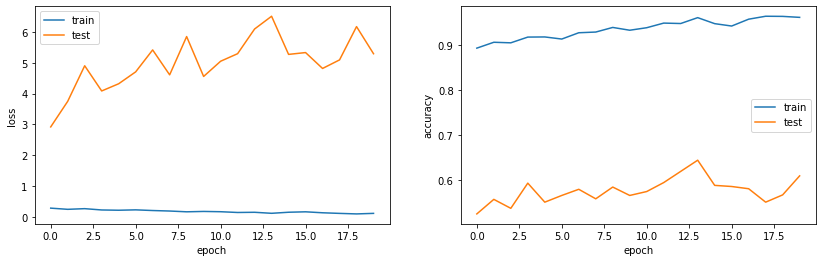

In [ ]:
show_results(history)

In [ ]:
history = vit_classifier.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=num_epochs
    )

Epoch 1/20
50/50 [==============================] - 73s 1s/step - loss: 0.0784 - accuracy: 0.9697 - top-5-accuracy: 1.0000 - val_loss: 6.4785 - val_accuracy: 0.5750 - val_top-5-accuracy: 1.0000
Epoch 2/20
50/50 [==============================] - 71s 1s/step - loss: 0.0654 - accuracy: 0.9750 - top-5-accuracy: 1.0000 - val_loss: 6.1569 - val_accuracy: 0.6037 - val_top-5-accuracy: 1.0000
Epoch 3/20
50/50 [==============================] - 72s 1s/step - loss: 0.1149 - accuracy: 0.9625 - top-5-accuracy: 1.0000 - val_loss: 7.8650 - val_accuracy: 0.6162 - val_top-5-accuracy: 1.0000
Epoch 4/20
50/50 [==============================] - 71s 1s/step - loss: 0.1126 - accuracy: 0.9578 - top-5-accuracy: 1.0000 - val_loss: 6.2836 - val_accuracy: 0.5813 - val_top-5-accuracy: 1.0000
Epoch 5/20
50/50 [==============================] - 72s 1s/step - loss: 0.0862 - accuracy: 0.9666 - top-5-accuracy: 1.0000 - val_loss: 6.0436 - val_accuracy: 0.6200 - val_top-5-accuracy: 1.0000
Epoch 6/20
50/50 [============

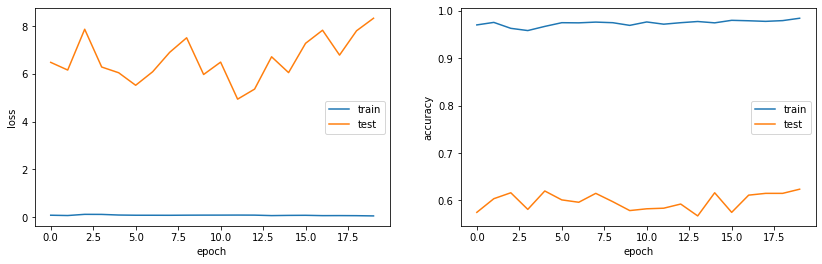

In [ ]:
show_results(history)